## Классификация текстов

<img src="http://vtm.e15.cz/files/imagecache/dust_filerenderer_big/upload/aktuality/ilustra_n__foto_4d0a03cf0b.jpg" alt="Robot reads book" style="width: 300px; float: right;"/>

Зачем?
* Определение тональности обращения
* Определение авторства текста
* Определение спама
* Определение намерения обращения
* Определение категорий (тегов)

Варианты подходов которые мы рассмотрим:
1. TF-IDF + Logit
1. Average W2V Vector
1. N-Char + CNN

### Задача отнесения новости к категории

Возможные кейсы:
- Вы крупная новостная компания которая не успевает следить за потоком новостей и разделять их по категориям
- Вы агрегатор новостей который собирает новости с разных сайтов у которых свои категории

### С чего будем начинать?

1. Собрать данные
1. Почистить данные от мусора
1. Токенизировать данные
1. Провести лемматизацию если требуется
1. Закодировать данные в какой нибудь вид
1. Выбрать алгоритм классификации

### Подгоотовка данных

Папка с данными: https://goo.gl/xJeD6V 
- lenta_10000.csv - 7 классов, 10000 новостей для каждого класса, всего 70к. новостей
- lenta_1000.csv - 7 классов, 1000 новостей для каждого класса, всего 7к. новостей
- lenta_1000_lem.csv - 7 классов, 1000 новостей для каждого класса, всего 7к. новостей + лемматизированный текст

Список классов:
- world
- media
- life
- sport
- science
- economics
- culture

#### Импортируем необходимые библиотеки для работы

In [46]:
import numpy as np # Поддержка многомерных массивов, высокоуровневых математических функций для работы с многомерными массивами
import pandas as pd # Библиотека для обработки и анализа данных
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Функции для кодирования значений
from sklearn.model_selection import train_test_split # Функция для разбиения данных на тренировочную выборку и тестовую
from matplotlib import pyplot as plt # Библиотека для визуализации данных

%matplotlib inline

In [47]:
np.random.seed(42) # Устанавливаем seed для повторяемости результатов

#### Читаем данные

In [50]:
# df = pd.read_csv('lenta_1000.csv', index_col=0, dtype ={'text': str, 'tag': str, 'title': str})
df = pd.read_csv('lenta_1000.csv', index_col=0, dtype ={'text': str, 'tag': str, 'title': str, 'lem_text': str})

# Приводим столбцы к нужному типу данных
df['text'] = df['text'].apply(str)
df['tag'] = df['tag'].apply(str)
df['title'] = df['title'].apply(str)
# df['lem_text'] = df['lem_text'].apply(str)

In [51]:
df.head()

,title,text,tag
0,На севере Франции из-за авиабомбы эвакуировали...,Французские власти срочно эвакуировали 1500 че...,world
1,Пилоты Lufthansa приостановили забастовку.,Пилоты немецкой авиакомпании Lufthansa приняли...,world
2,В премьер-министра Турции метнули ботинок.,"Премьер-министр Турции Реджеп Тайип Эрдоган, н...",world
3,Эксперты отсоветовали бундесверу приобретать н...,Эксперты сухопутных сил бундесвера раскритиков...,world
4,В Италии разгромили международную банду наркот...,"Итальянская полиция в понедельник, 22 февраля,...",world


In [55]:
print(df[df['tag'] == 'life']['title'].sample(n=10).values)

['Древо веры. На Украине обнаружен новый нерукотворный лик Девы Марии'
 'Нижегородец оторвал руку гипсовому Ленину по политическим мотивам. '
 'Бизнесмен заменил возлюбленную похожей на нее секс-куклой. '
 'Американец разбил выигранную "Ламборгини" через шесть часов езды. '
 'Датчане признаны самыми счастливыми в Европе. '
 'В Барселоне запретили гулять в купальниках. '
 'Попавший в аварию американец неделю не мог выбраться из машины. '
 'Американские летчики требуют возобновить изучение НЛО. '
 '19-летняя москвичка стала "Красой России". '
 'Прыгуны с шестом проломили потолок аэропорта в Сиднее. ']


In [53]:
df['title'] = df['title'].apply(lambda x: x.replace('\xa0', ' '))

#### Смотрим сколько у нас примеров для каждого класса

In [57]:
df.tag.value_counts()

sport        1000
media        1000
culture      1000
science      1000
life         1000
economics    1000
world        1000
Name: tag, dtype: int64

#### Получаем токены из текста

- Нужно разбить текст на слова
- Нужно удалить пунктуацию
- Нужно удалить стоп слова

Текст: "Тут очень большой и очень, очень крутой текст который нам нужно разбить на токены." <br/>
Токены: "тут", "очень", "большой", "очень", "очень", "крутой", "текст", "который", "нужно", "разбить", "токены" 

In [58]:
import nltk
import string
from nltk.corpus import stopwords

# nltk.download('punkt') # Скачать словарь пунктуации
# nltk.download('stopwords') # Скачать словарь стоп слов

# nltk.download() # Скачиваем словари для работы NLTK
# Выполняем в консоле "python -m nltk.downloader all"
 
def tokenize(text):
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(text)
 
    #let's delete punctuation symbols
    tokens = [i for i in tokens if ( i not in string.punctuation )]
 
    #deleting stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
 
    #cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]
 
    return tokens

In [60]:
print(tokenize('Тут очень большой и очень, очень крутой текст который нам нужно разбить на токены.'))

['Тут', 'очень', 'большой', 'очень', 'очень', 'крутой', 'текст', 'который', 'нам', 'нужно', 'разбить', 'токены']


#### Лемматизируем текст

Для чего? <br/>
Нужно избавиться от словоформ, чтобы снизить размерность словарей

In [64]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def text_lemmatizer(text):
    lem_array = []
    for word in tokenize(text):
        word_info = morph.parse(word)[0]
        lem_array.append(f'{word_info.normal_form}_{word_info.tag.POS}')
    return ' '.join(lem_array)

In [65]:
text_lemmatizer('Привет всем слушателям конференции! Улыбнитесь если не спите!')

'привет_NOUN весь_ADJF слушатель_NOUN конференция_NOUN улыбнуться_VERB спать_VERB'

#### Лемматизируем корпус

In [63]:
%%time
df['lem_title'] = df['title'].apply(text_lemmatizer)

Wall time: 15.1 s


In [74]:
df.sample(n=5)

,title,text,tag,lem_title
2764,РЖД восстановили советскую льготу для студентов.,"Госкомпания ""Российские железные дороги"" (РЖД)...",economics,ржд_NOUN восстановить_VERB советский_ADJF льго...
1945,Российские почтовые интернет-службы впервые в ...,В четверг две крупнейшие российские бесплатные...,media,российский_ADJF почтовый_ADJF интернетом-служб...
6531,Участникам телевикторины предложили составить ...,Участников популярной британской телевикторины...,life,участник_NOUN телевикторина_NOUN предложить_VE...
4739,Ирак удвоил заказ на истребители F-16.,Министерство обороны Ирака разместило в США за...,science,ирак_NOUN удвоить_VERB заказ_NOUN истребитель_...
5079,Стинга упрекнули в лицемерии за концерт для до...,"Британский музыкант Гордон Самнер, более извес...",culture,стинг_NOUN упрекнуть_VERB лицемерие_NOUN конце...


In [12]:
# df.to_csv('lenta_1000_lem.csv', encoding='utf-8') # Сохраняем результат

#### Закодируем текстовое описание категории в лейблы

In [75]:
count_tags = len(df.tag.value_counts().index.values)
tags = df.tag.value_counts().index.values

lableEnc = LabelEncoder()
lableEnc.fit(tags) 
lables = lableEnc.transform(tags).reshape((count_tags, 1))

def tag_to_lable(tag):
    return lableEnc.transform([tag])[0]

df['y'] = df['tag'].apply(tag_to_lable)

In [76]:
df.sample(n=5)

,title,text,tag,lem_title,y
5326,"Гаэль Гарсиа Берналь пропустит церемонию ""Оска...",В воскресенье мексиканский актер Гаэль Гарсиа ...,culture,гаэль_NOUN гарсиа_NOUN берналя_NOUN пропустить...,0
1740,"Телепрограмма ""Что? Где? Когда?"" перестает пла...","Телепрограмма ""Что? Где? Когда?"" перестанет вы...",media,телепрограмма_NOUN ``_None что_CONJ где_ADVB к...,3
2563,Сбербанк по притоку вкладов опередил все банки...,В декабре 2010 года в Сбербанке вклады выросли...,economics,сбербанк_NOUN приток_NOUN вклад_NOUN опередить...,1
1401,"""Манчестер Юнайтед"" нашел нового спонсора.","Английский футбольный клуб ""Манчестер Юнайтед""...",media,``_None манчестер_NOUN юнайтед_NOUN ''_None на...,3
837,Во Франции зафиксирована первая смерть от кише...,Во Франции зарегистрирована первая смерть от в...,world,в_PREP франция_NOUN зафиксировать_PRTS один_AD...,6


### Model №1 TF-IDF + LOGIT

### TF-IDF
TF-IDF - статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции.


$$ tf_{i,j} = \frac{n_{i,j}}{\sum_k n_{k,j}} $$

$$ idf_i = \mbox{log} \frac{|D|}{|{d : t_i \in d}|} $$

$$ tfidf_{i,j} = tf_{i,j} * idf_{i}$$

**Корпус:** <br/>
["очень", "очень", "важный", "текст", "про", "it"] <br/>
["текст", "про", "челябинск"] <br/>
<br/>
**Создаем "мешок слов":** <br/>
{ "очень": 1, "важный": 1, "текст": 2, "про": 2, "it": 1, "челябинск": 1 } <br/>
<br/>
**Считаем IDF каждого слова:** <br/>
{ "очень": 0.3, "важный": 0.3, "текст": 0, "про": 0, "it": 0.3, "челябинск": 0.3 } <br/>
 <br/>
**Получаем вектора для текстов:** <br/>
[0.6, 0.3, 0.0, 0.0, 0.3, 0.0] <br/>
[0.0, 0.0, 0.0, 0.0, 0.0, 0.3]

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [79]:
%%time
tfidf_vectorizer = TfidfVectorizer(lowercase=True, max_features=10000)
# tfidf_vectors = tfidf_vectorizer.fit_transform(df['title'].values)
# tfidf_vectors = tfidf_vectorizer.fit_transform(df['text'].values)
tfidf_vectors = tfidf_vectorizer.fit_transform(df['lem_title'].values)

Wall time: 167 ms


In [83]:
X_train, X_test, y_train, y_test = train_test_split(vectors, df['y'], test_size=0.2, random_state=42)

### logistics regression
<img src="https://habrastorage.org/files/77b/af8/55c/77baf855c84a4ba9a851060ec7ae6ec8.png" alt="Logit" style="width: 300px; float: center;"/>

Теория по линейным моделям классификации: <br/>
https://habrahabr.ru/company/ods/blog/323890/ <br/>
https://www.youtube.com/watch?v=HZEWIjEQ9A8 <br/>

In [89]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=42, multi_class='multinomial', solver='saga')
logit.fit(X_train, y_train)

Wall time: 319 ms


In [90]:
y_pred = logit.predict(X_test)

In [91]:
accuracy_score(y_test, y_pred)

0.69928571428571429

In [92]:
print(classification_report(y_test, y_pred, target_names=lableEnc.classes_))

             precision    recall  f1-score   support

    culture       0.70      0.64      0.67       211
  economics       0.73      0.75      0.74       178
       life       0.48      0.67      0.56       186
      media       0.84      0.64      0.73       224
    science       0.65      0.70      0.67       183
      sport       0.91      0.83      0.87       215
      world       0.69      0.66      0.68       203

avg / total       0.72      0.70      0.70      1400



#### Интерпретируем модель

In [93]:
id2word_tfidf = {y:x for x, y in tfidf_vectorizer.vocabulary_.items()}

In [94]:
tag_id_for_impotence = 2
dict_word_weight = {id2word_tfidf[index]:value for index, value in enumerate(logit.coef_[tag_id_for_impotence])}
sorted(dict_word_weight.items(), key=lambda x: x[1], reverse=True)[:10]

[('в_prep', 2.8391047625318073),
 ('житель_noun', 2.4436032888690256),
 ('собака_noun', 2.1280665551799958),
 ('британский_adjf', 2.0148087617914312),
 ('британец_noun', 1.8561636769992869),
 ('американец_noun', 1.8373490701693225),
 ('жительница_noun', 1.8314514949825789),
 ('медведь_noun', 1.6625378398250059),
 ('зоопарк_noun', 1.6095221649947054),
 ('школьник_noun', 1.5182682750950156)]

In [98]:
# my_news = text_lemmatizer('чемпионат мира по футболу скоро начнется')
my_news = text_lemmatizer('крокодил повесился')
print('Текст новости:', my_news)
query_vector = tfidf_vectorizer.transform([my_news])
lable = logit.predict(query_vector)
print('Категория:', lableEnc.inverse_transform(lable)[0])

Текст новости: крокодил_NOUN повеситься_VERB
Категория: life


### Average Word2Vec
<img src="http://www.samyzaf.com/ML/nlp/word2vec2.png" alt="Word2Vec" style="width: 600px; float: center;"/>

Какие слова являются близкими? Слова которые находятся в одинаковых контекстах: <br/>
- My name is **Ivan**
- My name is **Vasya**

Библиотека для работы с Word2Vec: https://radimrehurek.com/gensim/ <br/>
Примеры применения: https://habrahabr.ru/post/249215/ <br/>

In [100]:
import gensim # Библиотека для работы с word2vec моделью

In [101]:
def transform(word2vec, X): # Получаем средний вектор текста
        return np.array([np.mean([word2vec[word] for word in sent.split() if word in word2vec] or 
                                 [np.zeros(w2v_model.vector_size)], axis=0)
                         for sent in X])

In [102]:
# Готовые модели на http://rusvectores.org/ru/models/

w2v_model = gensim.models.KeyedVectors.load_word2vec_format('news_upos_cbow_300_2_2017.bin.gz', binary=True)

In [103]:
w2v_model.wv.most_similar(['политика_NOUN'])

[('стратегия_NOUN', 0.39227014780044556),
 ('госполитика_NOUN', 0.3522140383720398),
 ('реформа_NOUN', 0.34776410460472107),
 ('развитие_NOUN', 0.34623318910598755),
 ('дкп_NOUN', 0.3374726176261902),
 ('агрополитика_NOUN', 0.329285204410553),
 ('соцполитика_NOUN', 0.31780004501342773),
 ('сотрудничество_NOUN', 0.31736862659454346),
 ('регулирование_NOUN', 0.3144778609275818),
 ('риторика_NOUN', 0.31168729066848755)]

In [104]:
%%time
w2v_vectors = transform(w2v_model, df['lem_title'])

Wall time: 298 ms


In [105]:
w2v_vectors[:5]

array([[-0.02778414,  0.04538111, -0.01346011, ..., -0.01330944,
         0.00372368,  0.04422302],
       [-0.12382127,  0.09241188, -0.0324489 , ..., -0.01474568,
         0.06540877, -0.05289292],
       [ 0.05687089,  0.00616305, -0.05236949, ..., -0.00913587,
        -0.02160111,  0.02361445],
       [-0.04806248, -0.0448659 ,  0.01077042, ...,  0.01814298,
         0.01506669,  0.05181568],
       [-0.02760871,  0.00361723,  0.00202058, ...,  0.05358928,
        -0.04849855,  0.03099057]])

In [106]:
X_train, X_test, y_train, y_test = train_test_split(w2v_vectors, df['y'], test_size=0.2, random_state=42)

In [107]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=42, multi_class='multinomial', solver='saga')
logit.fit(X_train, y_train)

Wall time: 2.86 s


In [109]:
y_pred = logit.predict(X_test)

In [110]:
accuracy_score(y_test, y_pred)

0.69785714285714284

In [111]:
print(classification_report(y_test, y_pred, target_names=lableEnc.classes_))

             precision    recall  f1-score   support

    culture       0.74      0.73      0.73       211
  economics       0.70      0.85      0.76       178
       life       0.57      0.58      0.57       186
      media       0.75      0.57      0.65       224
    science       0.59      0.63      0.61       183
      sport       0.88      0.85      0.86       215
      world       0.66      0.68      0.67       203

avg / total       0.70      0.70      0.70      1400



Почему такие результаты

## Deep Learning for Text Classification

### CNN + CHAR N GRAMS

#### Кодировка текста
**Корпус**<br/>
["очень, очень важный текст про it"]<br/> 
["текст  про челябинск"]<br/>
<br/>
**Создаем "мешок слов"**: <br/>
{ "оче": 0, "чен": 1, "ень": 2, "нь,": 3, "ь, ": 4, ", о": 5, .... }<br/> 
<br/>
**Получаем вектора для текста**<br/>
[0, 1, 2, 3, 4, 5, ....]<br/>
[10, 11, 4, 5, 11, ....]<br/>

### Convolutional Neural Network (CNN) for Text Classification

<img src="http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM-1024x413.png" alt="Word2Vec" style="width: 700px; float: center;"/>
Теория: https://towardsdatascience.com/understanding-how-convolutional-neural-network-cnn-perform-text-classification-with-word-d2ee64b9dd0b

In [112]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer

In [113]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, TimeDistributed, Bidirectional
from keras.layers import LSTM, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

In [114]:
def texts2ngrams(texts, n=3, lowercase=True):
    """ Convert text into character ngrams. """
    vectors = []
    dict_grams = {}
    char_index = 0
    for text in texts:
        if lowercase:
            text = text.lower()
        vector = []
        grams_for_text = ["".join(j) for j in zip(*[text[i:] for i in range(n)])]
        for gram in grams_for_text:
            if gram in dict_grams:
                vector.append(dict_grams[gram])
            else:
                dict_grams[gram] = char_index
                vector.append(char_index)
                char_index += 1
        vectors.append(vector)
    count_grams = len(dict_grams)
    print('Количество уникальных ngrams:', count_grams)
    return vectors, count_grams

In [115]:
def print_plot_mean(x):
    lens = [len(y) for y in x]
    print('Max len:', max(lens))
    plt.plot(lens);

Количество уникальных ngrams: 14306
Max len: 156
Wall time: 367 ms


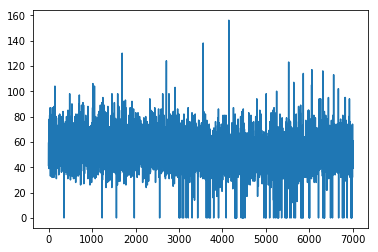

In [137]:
%%time
gram_vectors, count_grams = texts2ngrams(df['title'])
print_plot_mean(gram_vectors)

In [125]:
X = keras.preprocessing.sequence.pad_sequences(gram_vectors, maxlen=150)     
y = keras.utils.to_categorical(df['y'], count_tags)

In [142]:
X[155]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0, 2919, 2293,  513,  254, 1305,
       2793, 2314,  877, 1030,  974,  901,  585,    2, 2572, 1978, 2260,
       2920,  321,  247,  248,  249,  250, 1614,  480, 1529,  191, 1151,
        877, 2921,  162,  803,    1,  972,   80,   81,  406, 2922,  283,
       1729,  480, 1730, 1731, 1732, 1733, 2724, 2110,  475,  476,  477,
        478, 2923, 2924, 2925, 2420, 2423, 2424,  422,  401, 2403, 1917,
       1654, 1655, 1656,  476,  657, 2663, 1471])

In [143]:
y[155]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [131]:
def get_conv_model(embeding_size, num_classes):
    model = Sequential()
    model.add(Embedding(embeding_size, 300))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
%%time
model = get_conv_model(embeding_size=count_grams, num_classes=count_tags)
model.summary()

BATCH_SIZE = 128
EPOCHS = 8
VERBOSE = 1

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=VERBOSE,
                    validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         4291800   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 300)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 512)         461312    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 3591      
Total params: 4,756,703
Trainable params: 4,756,703
Non-trainable params: 0
_________________________________________________________________
Train on 5600 samples, validate on 1400 samples
Epoch 1/8
5600/5600 [==============================] - 125s - loss: 1.8950 - acc: 0.

In [134]:
print('Точность модели составляет: {}'.format(model.evaluate(X_test, y_test, batch_size=64, verbose=2)[1] * 100))

Точность модели составляет: 72.07142846924917


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


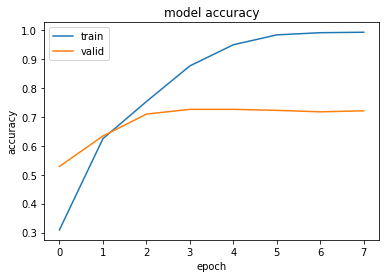

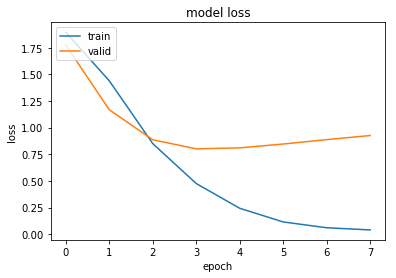

In [135]:
from matplotlib import pyplot as plt
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();

### Результаты (Accuracy)
TF-IDF + LogIt = 69.92 <br/>
Word2Vec + LogIt = 69.78 <br/>
Char n-grams + CNN = 72.07 <br/>